# Basic sampler example: Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial import distance_matrix

import tinyDA as tda
import umbridge

In [2]:
np.random.seed(789)

### Defining the true model and generating some data

In [3]:
umbridge_model = umbridge.HTTPModel('http://0.0.0.0:4242', "forward")

E = lambda x: 1e5*np.exp(x)

my_model = tda.UmBridgeModel(umbridge_model, pre=E)

In [4]:
nx = umbridge_model.get_input_sizes()[0]
ny = umbridge_model.get_output_sizes()[0]

x = np.linspace(0, 1, nx)

l = 0.5
C = np.exp(-0.5*distance_matrix(x[:,np.newaxis], x[:, np.newaxis])**2/l**2)

my_prior = multivariate_normal(np.zeros(nx), C, allow_singular=True)

In [5]:
var_e = 1e-3

log_E_true = my_prior.rvs()
d_true = my_model(log_E_true)
d = d_true + np.random.normal(loc=0, scale=var_e, size=ny)

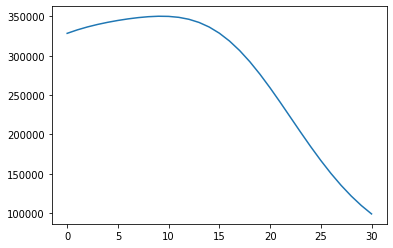

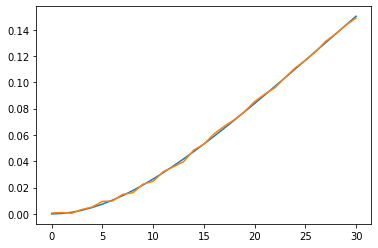

In [6]:
plt.plot(E(log_E_true))
plt.show()

plt.plot(d_true)
plt.plot(d)
plt.show()

### Set up the statistical model

In [7]:
# set the likelihood
cov_likelihood = var_e*np.eye(nx)
my_loglike = tda.GaussianLogLike(d, cov_likelihood)

In [8]:
# initialise the LinkFactory
my_link_factory = tda.BlackBoxLinkFactory(my_model, my_prior, my_loglike)

### Set up the proposal

In [9]:
# preconditioned Crank-Nicolson
pcn_scaling = 0.1
pcn_adaptive = True
my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

### Sample

In [10]:
my_chains = tda.sample(my_link_factory, my_proposal, iterations=60000, n_chains=2, force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.21: 100%|███████████| 60000/60000 [02:30<00:00, 399.23it/s]


Sampling chain 2/2


Running chain, α = 0.16: 100%|███████████| 60000/60000 [02:37<00:00, 380.55it/s]


### Get some diagnostics

In [11]:
import arviz as az

In [12]:
idata = tda.to_inference_data(my_chains, burnin=10000)

/home/mikkel/venv/tinyda/lib/python3.8/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,0.162,0.860,-1.431,1.625,0.024,0.017,1253.0,2635.0,1.0
theta_1,0.171,0.852,-1.431,1.592,0.024,0.017,1251.0,2546.0,1.0
theta_2,0.180,0.843,-1.332,1.643,0.024,0.017,1249.0,2537.0,1.0
theta_3,0.189,0.832,-1.299,1.633,0.024,0.017,1249.0,2537.0,1.0
theta_4,0.199,0.821,-1.266,1.635,0.023,0.016,1250.0,2529.0,1.0
theta_5,0.209,0.808,-1.200,1.669,0.023,0.016,1253.0,2483.0,1.0
theta_6,0.219,0.794,-1.223,1.620,0.022,0.016,1258.0,2451.0,1.0
theta_7,0.230,0.778,-1.149,1.654,0.022,0.015,1264.0,2448.0,1.0
theta_8,0.241,0.760,-1.126,1.621,0.021,0.015,1270.0,2492.0,1.0
theta_9,0.251,0.740,-1.086,1.603,0.021,0.015,1279.0,2506.0,1.0


/home/mikkel/venv/tinyda/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (31), generating only 20 plots
  warnings.warn(


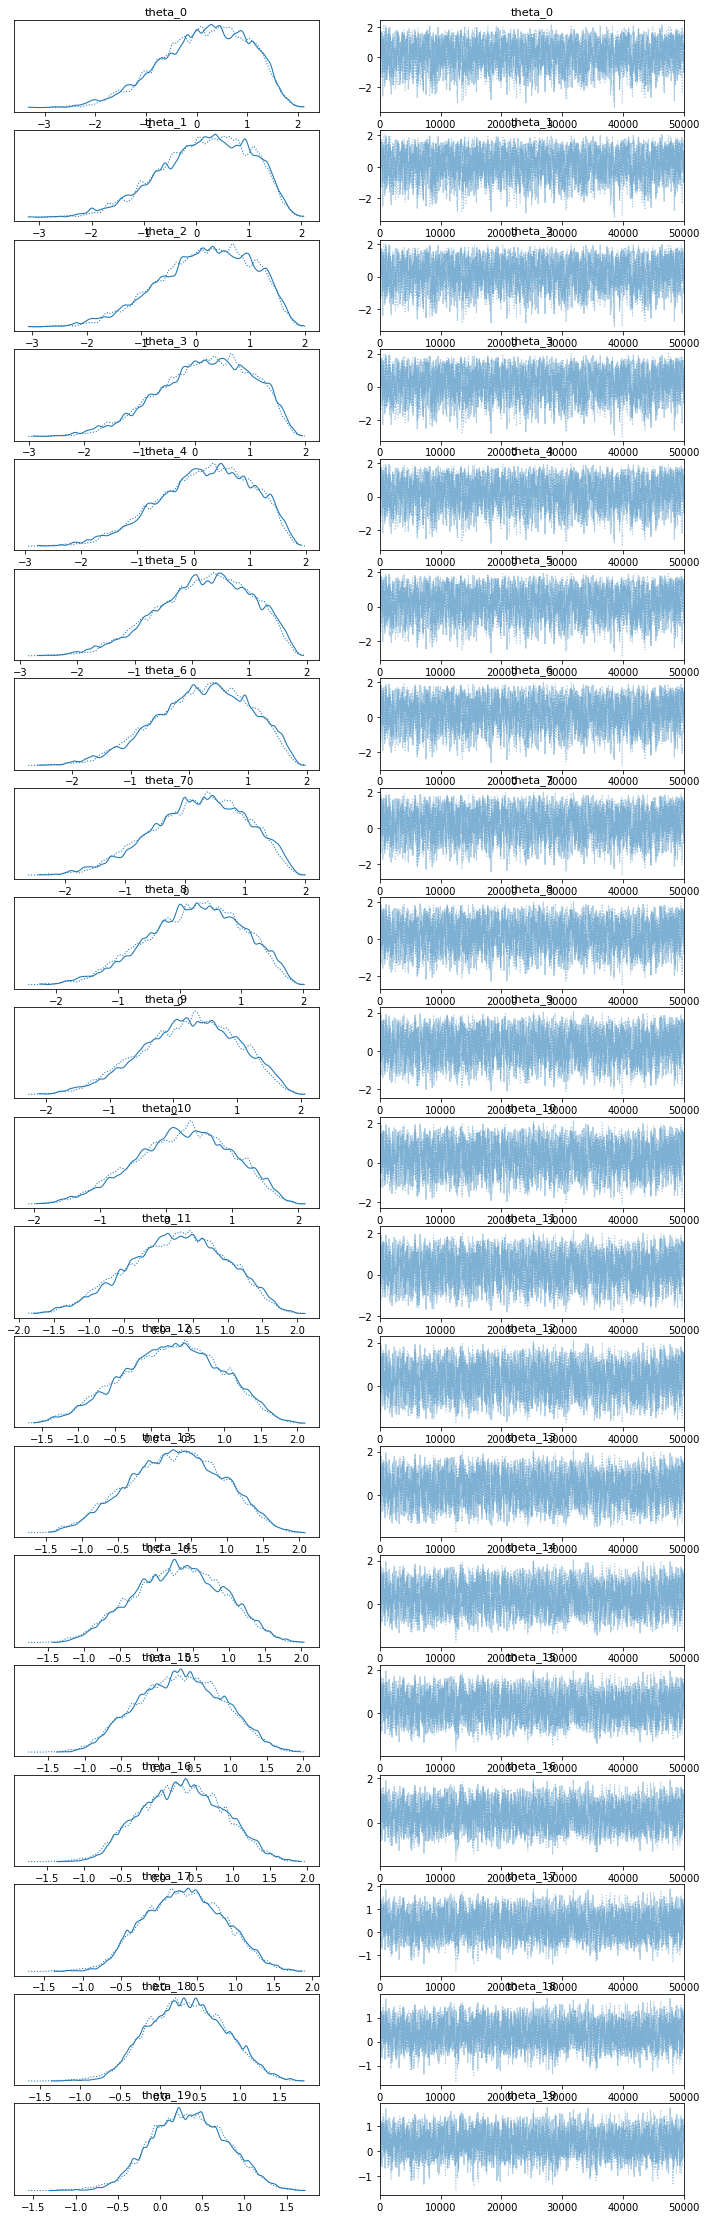

In [14]:
az.plot_trace(idata)
plt.show()

In [15]:
parameters = [link.parameters for link in my_chains['chain_0'][2001:] + my_chains['chain_1'][2001:]]

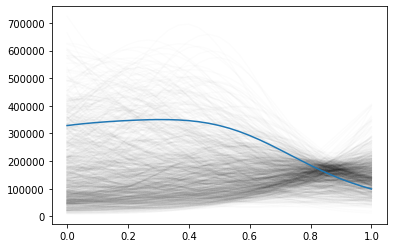

In [16]:
n_samples = 1000
ids = np.random.randint(0, len(parameters), n_samples)
for id in ids:
    plt.plot(x, E(parameters[id]), c='k', alpha=0.01)
plt.plot(x, 1e5*np.exp(log_E_true))
plt.show()

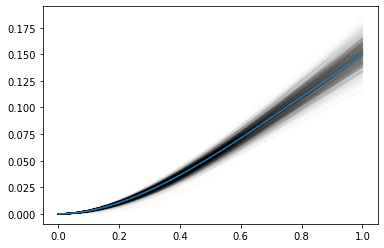

In [17]:
n_samples = 1000
ids = np.random.randint(0, len(parameters), n_samples)
for id in ids:
    plt.plot(x, my_model(parameters[id]), c='k', alpha=0.01)
plt.plot(x, d_true)
plt.show()